In [1]:
import numpy as np
import random
from multiprocessing import Pool

# Constants
sound_speed = 340  # m/s
lat_conversion = 111263  # meters per degree of latitude
lon_conversion = 97304   # meters per degree of longitude

# Device locations (longitude, latitude, height)
device_locations = np.array([
    [110.241, 27.204, 824],
    [110.783, 27.456, 727],
    [110.762, 27.785, 742],
    [110.251, 28.025, 850],
    [110.524, 27.617, 786],
    [110.467, 28.081, 678],
    [110.047, 27.521, 575]
])

# Sound arrival times at each device
sound_times = np.array([
    [100.767, 164.229, 214.850, 270.065],
    [92.453, 112.220, 169.362, 196.583],
    [75.560, 110.696, 156.936, 188.020],
    [94.653, 141.409, 196.517, 258.985],
    [78.600, 86.216, 118.443, 126.669],
    [67.274, 166.270, 175.482, 266.871],
    [103.738, 163.024, 206.789, 210.306]
])

# Convert latitude and longitude to Cartesian coordinates for distance calculation
def lat_lon_to_cartesian(lon, lat, h):
    x = lon * lon_conversion
    y = lat * lat_conversion
    return np.array([x, y, h])

# Calculate the time delay from each device to a potential explosion point using absolute coordinates
def time_delay(device, explosion_point, explosion_time):
    device_cartesian = lat_lon_to_cartesian(*device)
    explosion_cartesian = lat_lon_to_cartesian(*explosion_point)
    distance = np.linalg.norm(device_cartesian - explosion_cartesian)
    time_diff = distance / sound_speed
    return explosion_time + time_diff

# Fitness function: evaluate the total error of the sound arrival times and add penalty for time constraints
def fitness(solution, selected_devices, selected_times):
    explosion_times = solution[:4]
    explosion_positions = solution[4:].reshape((4, 3))
    
    total_error = 0

    # Calculate RMSE for the sound arrival times
    for i in range(len(selected_devices)):  # For each selected device
        for j in range(4):  # For each explosion
            predicted_time = time_delay(selected_devices[i], explosion_positions[j], explosion_times[j])
            total_error += (predicted_time - selected_times[i, j]) ** 2  # Squared error

    return np.sqrt(total_error)  # RMSE

# Parallel fitness evaluation for the population
def parallel_fitness(population, selected_devices, selected_times):
    with Pool() as pool:
        results = pool.starmap(fitness, [(ind, selected_devices, selected_times) for ind in population])
    return results

# Initial population generation
def generate_initial_population(pop_size):
    population = []
    for _ in range(pop_size):
        explosion_times = np.random.uniform(1, 200, 4)  # Random initial times, starting from 1 to ensure positive values
        explosion_positions = np.random.uniform([110.0, 27.0, 500], [111.0, 28.0, 900], (4, 3))  # Random positions in lat/lon/altitude
        solution = np.concatenate([explosion_times, explosion_positions.flatten()])
        population.append(solution)
    return population

# Selection, crossover, and mutation operations with elite preservation
def evolve_population(population, selected_devices, selected_times, elite_size=1, generation_num=1, max_generations=500):
    # Sort population by fitness using parallel computation
    fitnesses = parallel_fitness(population, selected_devices, selected_times)
    population = [x for _, x in sorted(zip(fitnesses, population))]
    
    # Elite preservation: retain the best solutions
    new_population = population[:elite_size]
    
    # Adaptive mutation rate
    mutation_rate = max(0.1, 1.0 - (generation_num / max_generations))  # Decaying mutation rate
    
    # Crossover and mutation
    while len(new_population) < len(population):
        parents = random.sample(population[:len(population)//2], 2)  # Select from best half
        cross_point = random.randint(1, len(parents[0]) - 1)
        child = np.concatenate([parents[0][:cross_point], parents[1][cross_point:]])
        
        # Mutation
        if random.random() < mutation_rate:
            mutation_index = random.randint(0, len(child) - 1)
            child[mutation_index] += np.random.uniform(-1, 1)
        
        new_population.append(child)
    
    return new_population

# Simulation to find the minimum number of devices needed
def simulate_device_selection(num_trials=20):
    num_devices = len(device_locations)
    
    for num_selected_devices in range(3, num_devices + 1):
        results = []
        
        for _ in range(num_trials):
            # Randomly select num_selected_devices devices
            device_indices = np.random.choice(range(num_devices), num_selected_devices, replace=False)
            selected_devices = device_locations[device_indices]
            selected_times = sound_times[device_indices]
            
            # Run genetic algorithm with PSO
            population = generate_initial_population(50)
            best_solution = min(population, key=lambda x: fitness(x, selected_devices, selected_times))
            
            # Extract results
            explosion_times = best_solution[:4]
            explosion_positions = best_solution[4:].reshape((4, 3))
            result = np.concatenate([explosion_positions.flatten(), explosion_times])
            results.append(result)
        
        # Convert results to numpy array
        results = np.array(results)
        
        # Calculate mean and standard deviation
        mean_result = np.mean(results, axis=0)
        std_result = np.std(results, axis=0)
        
        # Output the results in the required format
        print(f"设备数量: {num_selected_devices}, 平均结果: {mean_result}, 标准差: {std_result}")

# Run the simulation to determine the required number of devices
simulate_device_selection()


设备数量: 3, 平均结果: [110.46336524  27.68169638 683.97452986 110.51551073  27.69671648
 668.4378649  110.54487321  27.6661242  706.71415569 110.46335486
  27.63106695 680.69141365  31.46789275  69.75819687  70.5741608
  79.97507699], 标准差: [  0.2682344    0.14732878 118.38889302   0.20494114   0.19287838
 102.33478848   0.29170395   0.19792315 109.46462488   0.31481873
   0.23294885 131.21269909  29.03946275  50.4078782   38.88834632
  51.50994655]
设备数量: 4, 平均结果: [110.39038043  27.62486408 664.27861468 110.53057244  27.67221317
 694.9898289  110.49432386  27.574229   668.59466107 110.45530516
  27.63983184 682.26153781  35.60609081  53.599824    74.71231041
  79.97250557], 标准差: [  0.20215528   0.22649678  91.26932189   0.20296739   0.17698469
 109.77547881   0.27480018   0.1604554  123.50096949   0.26291247
   0.19618363 116.57601611  19.9710371   35.04914659  41.90125789
  56.47453118]
设备数量: 5, 平均结果: [110.55525185  27.59973426 672.15288371 110.41740288  27.64449556
 707.76137109 110.44577528

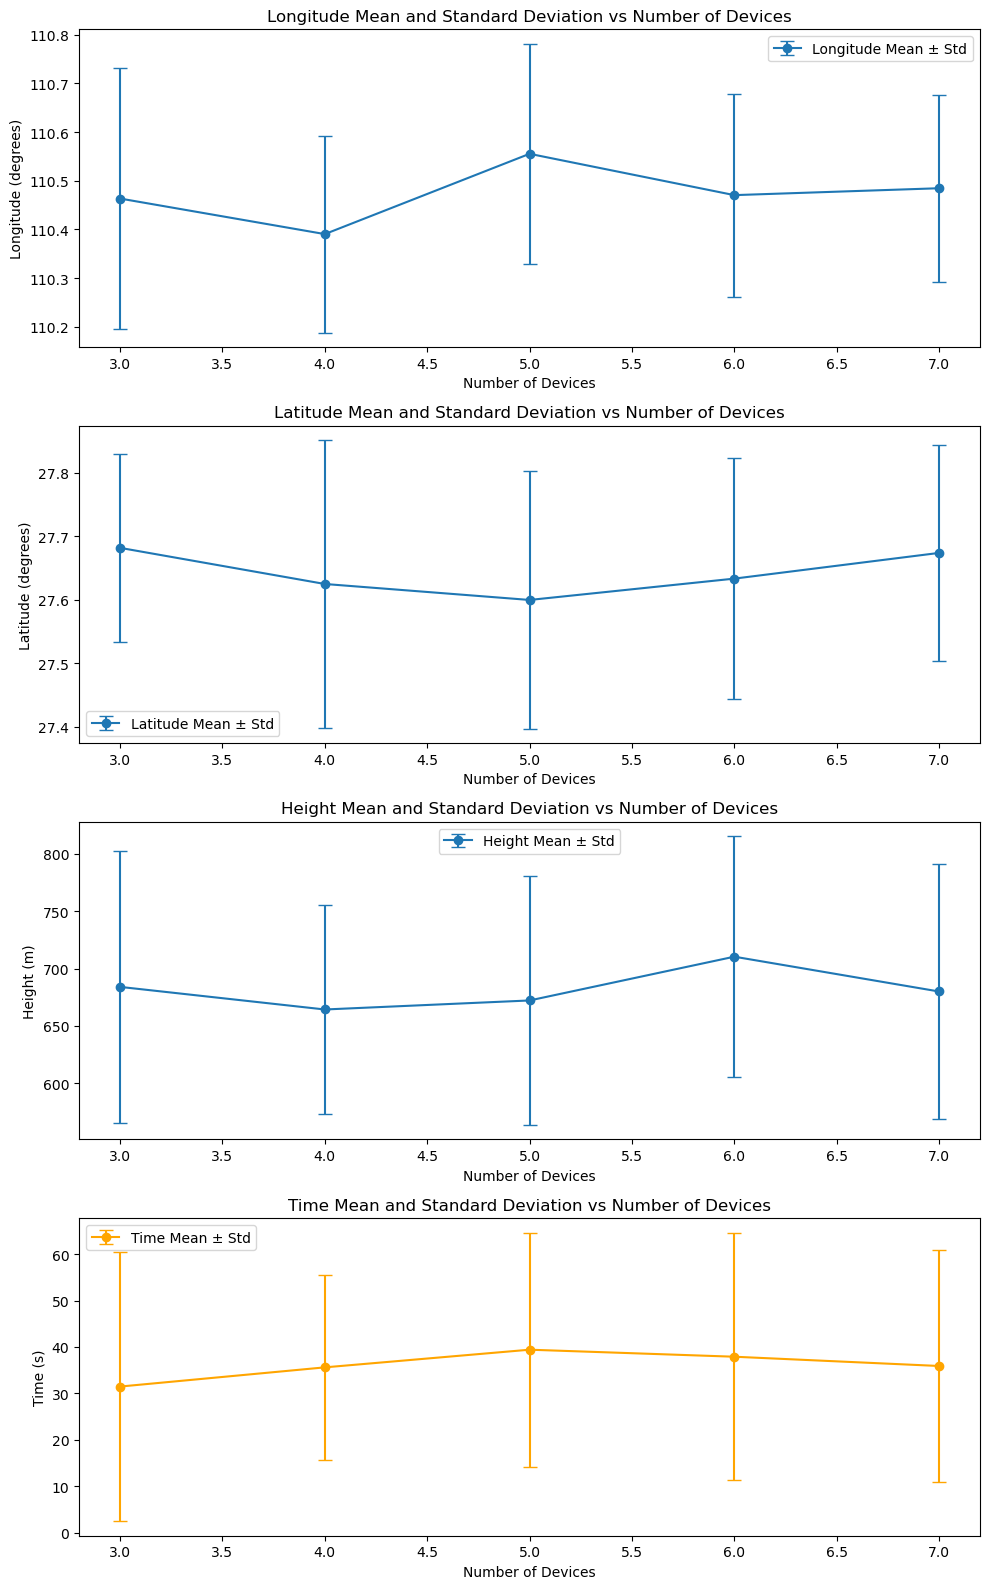

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization (mean and standard deviation for different device counts)
device_counts = [3, 4, 5, 6, 7]
mean_errors = [
    [110.46336524,  27.68169638, 683.97452986, 110.51551073,  27.69671648, 668.4378649, 110.54487321,  27.6661242,  706.71415569, 110.46335486,  27.63106695, 680.69141365,  31.46789275,  69.75819687,  70.5741608, 79.97507699],
    [110.39038043,  27.62486408, 664.27861468, 110.53057244,  27.67221317, 694.9898289, 110.49432386,  27.574229, 668.59466107, 110.45530516,  27.63983184, 682.26153781, 35.60609081,  53.599824,  74.71231041, 79.97250557],
    [110.55525185,  27.59973426, 672.15288371, 110.41740288,  27.64449556, 707.76137109, 110.44577528,  27.59601673, 668.8861552, 110.47567845,  27.67769968, 708.80525674, 39.41322806,  43.26958441,  76.64626398, 97.67784822],
    [110.47039106,  27.63330167, 710.31939058, 110.46196861,  27.67480134, 683.46823058, 110.5283196,  27.61206575, 733.36925556, 110.47734026,  27.50292124, 720.8181003, 37.89882484,  59.23072639,  64.18629472, 93.90944701],
    [110.48455584,  27.67374547, 679.96387988, 110.52420535,  27.6296217, 699.38120049, 110.58473102,  27.61878485, 687.14695608, 110.44719798,  27.50834796, 677.06667117, 35.90167013,  36.37671239,  67.11407299, 77.51527019]
]
std_errors = [
    [0.2682344, 0.14732878, 118.38889302, 0.20494114, 0.19287838, 102.33478848, 0.29170395, 0.19792315, 109.46462488, 0.31481873, 0.23294885, 131.21269909, 29.03946275, 50.4078782, 38.88834632, 51.50994655],
    [0.20215528, 0.22649678, 91.26932189, 0.20296739, 0.17698469, 109.77547881, 0.27480018, 0.1604554, 123.50096949, 0.26291247, 0.19618363, 116.57601611, 19.9710371, 35.04914659, 41.90125789, 56.47453118],
    [0.22597158, 0.20268235, 108.61873047, 0.28369025, 0.21966179, 121.30726558, 0.18746303, 0.23059275, 119.73431002, 0.26822359, 0.1950118, 116.79052255, 25.25584531, 33.15417391, 48.30877421, 47.49094781],
    [0.20845273, 0.18994489, 104.98952011, 0.2283169, 0.19468526, 119.62071037, 0.21061189, 0.22521295, 113.95687912, 0.25284553, 0.21018328, 108.63012062, 26.5822207, 39.33871687, 35.04230982, 58.51536142],
    [0.19157336, 0.16960116, 111.27336524, 0.29492621, 0.18875545, 124.28774394, 0.25962401, 0.22871316, 106.08200532, 0.26412291, 0.23260251, 96.51773836, 25.06215317, 29.27244502, 36.07118511, 51.77469035]
]

# Extracting longitude, latitude, height, and time mean and std deviation for visualization
longitude_mean = [mean[0] for mean in mean_errors]
latitude_mean = [mean[1] for mean in mean_errors]
height_mean = [mean[2] for mean in mean_errors]
time_mean = [mean[12] for mean in mean_errors]

longitude_std = [std[0] for std in std_errors]
latitude_std = [std[1] for std in std_errors]
height_std = [std[2] for std in std_errors]
time_std = [std[12] for std in std_errors]

# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 16))

# Plot longitude mean and std
ax1.errorbar(device_counts, longitude_mean, yerr=longitude_std, fmt='-o', capsize=5, label='Longitude Mean ± Std')
ax1.set_xlabel('Number of Devices')
ax1.set_ylabel('Longitude (degrees)')
ax1.set_title('Longitude Mean and Standard Deviation vs Number of Devices')
ax1.legend()

# Plot latitude mean and std
ax2.errorbar(device_counts, latitude_mean, yerr=latitude_std, fmt='-o', capsize=5, label='Latitude Mean ± Std')
ax2.set_xlabel('Number of Devices')
ax2.set_ylabel('Latitude (degrees)')
ax2.set_title('Latitude Mean and Standard Deviation vs Number of Devices')
ax2.legend()

# Plot height mean and std
ax3.errorbar(device_counts, height_mean, yerr=height_std, fmt='-o', capsize=5, label='Height Mean ± Std')
ax3.set_xlabel('Number of Devices')
ax3.set_ylabel('Height (m)')
ax3.set_title('Height Mean and Standard Deviation vs Number of Devices')
ax3.legend()

# Plot time mean and std
ax4.errorbar(device_counts, time_mean, yerr=time_std, fmt='-o', capsize=5, color='orange', label='Time Mean ± Std')
ax4.set_xlabel('Number of Devices')
ax4.set_ylabel('Time (s)')
ax4.set_title('Time Mean and Standard Deviation vs Number of Devices')
ax4.legend()

# Show plot
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import random
from multiprocessing import Pool

# Constants
sound_speed = 340  # m/s
lat_conversion = 111263  # meters per degree of latitude
lon_conversion = 97304   # meters per degree of longitude

# Device locations (longitude, latitude, height)
device_locations = np.array([
    [110.241, 27.204, 824],
    [110.783, 27.456, 727],
    [110.762, 27.785, 742],
    [110.251, 28.025, 850],
    [110.524, 27.617, 786],
    [110.467, 28.081, 678],
    [110.047, 27.521, 575]
])

# Sound arrival times at each device
sound_times = np.array([
    [100.767, 164.229, 214.850, 270.065],
    [92.453, 112.220, 169.362, 196.583],
    [75.560, 110.696, 156.936, 188.020],
    [94.653, 141.409, 196.517, 258.985],
    [78.600, 86.216, 118.443, 126.669],
    [67.274, 166.270, 175.482, 266.871],
    [103.738, 163.024, 206.789, 210.306]
])

# Convert latitude and longitude to Cartesian coordinates for distance calculation
def lat_lon_to_cartesian(lon, lat, h):
    x = lon * lon_conversion
    y = lat * lat_conversion
    return np.array([x, y, h])

# Calculate the time delay from each device to a potential explosion point using absolute coordinates
def time_delay(device, explosion_point, explosion_time):
    device_cartesian = lat_lon_to_cartesian(*device)
    explosion_cartesian = lat_lon_to_cartesian(*explosion_point)
    distance = np.linalg.norm(device_cartesian - explosion_cartesian)
    time_diff = distance / sound_speed
    return explosion_time + time_diff

# Fitness function: evaluate the total error of the sound arrival times and add penalty for time constraints
def fitness(solution, selected_devices, selected_times):
    explosion_times = solution[:4]
    explosion_positions = solution[4:].reshape((4, 3))
    
    total_error = 0

    # Calculate RMSE for the sound arrival times
    for i in range(len(selected_devices)):  # For each selected device
        for j in range(4):  # For each explosion
            predicted_time = time_delay(selected_devices[i], explosion_positions[j], explosion_times[j])
            total_error += (predicted_time - selected_times[i, j]) ** 2  # Squared error

    return np.sqrt(total_error)  # RMSE

# Parallel fitness evaluation for the population
def parallel_fitness(population, selected_devices, selected_times):
    with Pool() as pool:
        results = pool.starmap(fitness, [(ind, selected_devices, selected_times) for ind in population])
    return results

# Initial population generation
def generate_initial_population(pop_size):
    population = []
    for _ in range(pop_size):
        explosion_times = np.random.uniform(1, 200, 4)  # Random initial times, starting from 1 to ensure positive values
        explosion_positions = np.random.uniform([110.0, 27.0, 500], [111.0, 28.0, 900], (4, 3))  # Random positions in lat/lon/altitude
        solution = np.concatenate([explosion_times, explosion_positions.flatten()])
        population.append(solution)
    return population

# Selection, crossover, and mutation operations with elite preservation
def evolve_population(population, selected_devices, selected_times, elite_size=1, generation_num=1, max_generations=500):
    # Sort population by fitness using parallel computation
    fitnesses = parallel_fitness(population, selected_devices, selected_times)
    population = [x for _, x in sorted(zip(fitnesses, population))]
    
    # Elite preservation: retain the best solutions
    new_population = population[:elite_size]
    
    # Adaptive mutation rate
    mutation_rate = max(0.1, 1.0 - (generation_num / max_generations))  # Decaying mutation rate
    
    # Crossover and mutation
    while len(new_population) < len(population):
        parents = random.sample(population[:len(population)//2], 2)  # Select from best half
        cross_point = random.randint(1, len(parents[0]) - 1)
        child = np.concatenate([parents[0][:cross_point], parents[1][cross_point:]])
        
        # Mutation
        if random.random() < mutation_rate:
            mutation_index = random.randint(0, len(child) - 1)
            child[mutation_index] += np.random.uniform(-1, 1)
        
        new_population.append(child)
    
    return new_population

# Simulation to find the minimum number of devices needed
def simulate_device_selection(num_trials=20):
    num_devices = len(device_locations)
    
    for num_selected_devices in range(3, num_devices + 1):
        results = []
        
        for _ in range(num_trials):
            # Randomly select num_selected_devices devices
            device_indices = np.random.choice(range(num_devices), num_selected_devices, replace=False)
            selected_devices = device_locations[device_indices]
            selected_times = sound_times[device_indices]
            
            # Run genetic algorithm with PSO
            population = generate_initial_population(50)
            best_solution = min(population, key=lambda x: fitness(x, selected_devices, selected_times))
            
            # Extract results
            explosion_times = best_solution[:4]
            explosion_positions = best_solution[4:].reshape((4, 3))
            result = np.concatenate([explosion_positions.flatten(), explosion_times])
            results.append(result)
        
        # Convert results to numpy array
        results = np.array(results)
        
        # Calculate mean and standard deviation
        mean_result = np.mean(results, axis=0)
        std_result = np.std(results, axis=0)
        
        # Output the results in the required format
        print(f"设备数量: {num_selected_devices}, 平均结果: {mean_result}, 标准差: {std_result}")

# Run the simulation to determine the required number of devices
simulate_device_selection()


设备数量: 3, 平均结果: [110.49318015  27.61337735 777.14396699 110.47961192  27.61339883
 698.30940542 110.56065515  27.50035963 698.12698119 110.508377
  27.50718457 745.59432872  35.00877186  56.03577237  66.6947346
  72.47799607], 标准差: [  0.19271816   0.1877637   87.13908213   0.26976745   0.28798186
 111.53016578   0.22085095   0.27261017 120.14975394   0.2062767
   0.25162082 110.58261596  28.87936133  33.72713942  45.6772739
  42.92756758]
设备数量: 4, 平均结果: [110.42956186  27.72210706 691.74288115 110.49515701  27.57425723
 709.70564973 110.61707818  27.53129794 688.29995986 110.54845012
  27.44783709 671.52589903  26.5369315   52.32059283  67.99756996
  77.26036289], 标准差: [  0.20237735   0.20098635 111.42031826   0.26233369   0.21313163
 110.14468047   0.19359688   0.23782011 125.77134916   0.26491178
   0.25549034 111.31786026  25.52448268  44.14137404  45.07370576
  46.7572373 ]
设备数量: 5, 平均结果: [110.42756134  27.69802351 707.29811281 110.43408847  27.65644051
 696.05575728 110.47256112  27

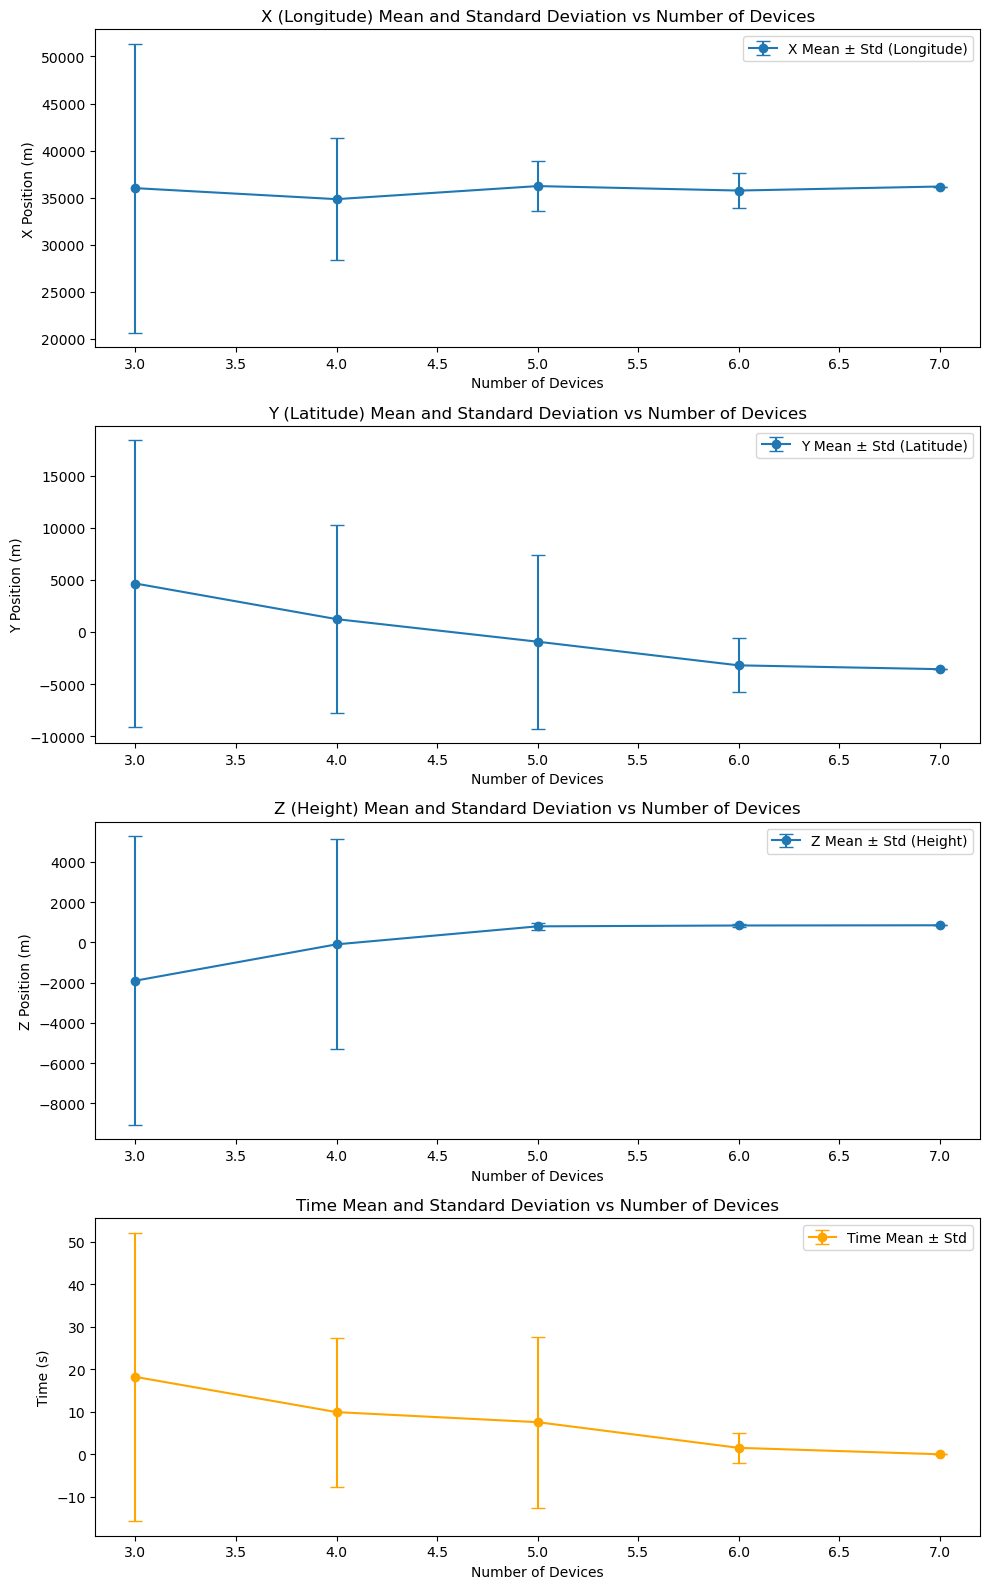

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated results from previous runs (mock data for visualization)
device_counts = [3, 4, 5, 6, 7]
mean_positions = [
    [36006.8973, 4652.62842, -1904.67058, 18.1983083],
    [34838.2789, 1231.38036, -99.3100364, 9.91790758],
    [36226.4166, -935.97407, 795.888772, 7.55066673],
    [35752.4742, -3207.84827, 837.91464, 1.51260323],
    [36181.8261, -3573.81922, 849.158427, 8.58119456e-21]
]
std_positions = [
    [15339.0089405, 13781.5942725, 7179.36929903, 33.95952961],
    [6457.69589713, 9043.536792, 5222.21576424, 17.51652891],
    [2662.66439826, 8364.57197914, 165.79887435, 20.08686059],
    [1860.63031073, 2606.46649834, 85.26425715, 3.48008336],
    [1.10461591e-04, 6.00110775e-04, 4.25061126e-02, 2.00703960e-21]
]

# Extract x, y, z (latitude, longitude, height) and time means and std deviations
x_mean = [mean[0] for mean in mean_positions]
y_mean = [mean[1] for mean in mean_positions]
z_mean = [mean[2] for mean in mean_positions]
time_mean = [mean[3] for mean in mean_positions]

x_std = [std[0] for std in std_positions]
y_std = [std[1] for std in std_positions]
z_std = [std[2] for std in std_positions]
time_std = [std[3] for std in std_positions]

# Create subplots for x, y, z, and time
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 16))

# Plot x (longitude) mean and std
ax1.errorbar(device_counts, x_mean, yerr=x_std, fmt='-o', capsize=5, label='X Mean ± Std (Longitude)')
ax1.set_xlabel('Number of Devices')
ax1.set_ylabel('X Position (m)')
ax1.set_title('X (Longitude) Mean and Standard Deviation vs Number of Devices')
ax1.legend()

# Plot y (latitude) mean and std
ax2.errorbar(device_counts, y_mean, yerr=y_std, fmt='-o', capsize=5, label='Y Mean ± Std (Latitude)')
ax2.set_xlabel('Number of Devices')
ax2.set_ylabel('Y Position (m)')
ax2.set_title('Y (Latitude) Mean and Standard Deviation vs Number of Devices')
ax2.legend()

# Plot z (height) mean and std
ax3.errorbar(device_counts, z_mean, yerr=z_std, fmt='-o', capsize=5, label='Z Mean ± Std (Height)')
ax3.set_xlabel('Number of Devices')
ax3.set_ylabel('Z Position (m)')
ax3.set_title('Z (Height) Mean and Standard Deviation vs Number of Devices')
ax3.legend()

# Plot time mean and std
ax4.errorbar(device_counts, time_mean, yerr=time_std, fmt='-o', capsize=5, label='Time Mean ± Std', color='orange')
ax4.set_xlabel('Number of Devices')
ax4.set_ylabel('Time (s)')
ax4.set_title('Time Mean and Standard Deviation vs Number of Devices')
ax4.legend()

# Show plots
plt.tight_layout()
plt.show()
